In [1]:
from tensorflow import keras
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import textwrap

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from scipy import interp
from itertools import cycle

In [2]:
phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan',
    'unknown': 'black'
}

In [3]:
efam_super_annote = pd.read_csv('../general_data_files/Final_Super_Condensed_Annotations-updated_efam.tsv', sep='\t')
## convert 'Proteins' column read in as a string into a column of lists
efam_super_annote['Proteins'] = efam_super_annote['Proteins'].apply(literal_eval)

In [4]:
efam_super_annote = efam_super_annote.set_index(keys='Cluster')

In [5]:
efam_cluster_protein_lengths = pd.read_csv('efam_cluster_average_protein_length.csv', header=None, names=['Cluster', 'average_protein_length'])

In [6]:
efam_super_annote

,Number of Proteins,Annotation Status,RANK(s):,Annotation(s) / Hit(s):,Proteins
Cluster,,,,,
cluster1,373,Unannotated,'C'=2; 'E'=1;,'No Annotation Found'=10; 'Uncharacterized pro...,[Station155_MES_ALL_assembly_NODE_1077_length_...
cluster10,244,Unannotated,'C'=2;,'No Annotation Found'=6; 'Uncharacterized prot...,[Station158_SUR_ALL_assembly_NODE_17979_length...
cluster100,142,Unannotated,'C'=1;,'No Annotation Found'=3; 'Uncharacterized prot...,[Station173_DCM_ALL_assembly_NODE_17311_length...
cluster1000,79,Annotated,'C'=2;,'No Annotation Found'=4; 'Predicted protein '=...,[Station102_DCM_ALL_assembly_NODE_256_length_4...
cluster10000,39,Annotated,'B'=4; 'C'=7;,' ATP-dependent DNA helicase; K03657 DNA helic...,[Station158_DCM_ALL_assembly_NODE_8123_length_...
...,...,...,...,...,...
cluster99995,5,Unannotated,'C'=1;,'No Annotation Found'=3; 'Uncharacterized prot...,[Station76_SUR_ALL_assembly_NODE_3552_length_9...
cluster99996,5,Annotated,'C'=2; 'E'=1;,'No Annotation Found'=7; 'Predicted protein '=...,[Station66_DCM_ALL_assembly_NODE_1688_length_1...
cluster99997,5,Unannotated,'C'=3;,' hypothetical protein'=3; 'Uncharacterized co...,[Station72_MES_ALL_assembly_NODE_5602_length_6...


In [7]:
efam_super_annote = efam_super_annote.merge(efam_cluster_protein_lengths, left_index=True, right_on='Cluster')
efam_super_annote = efam_super_annote.set_index(keys='Cluster')

In [8]:
efam_super_annote

,Number of Proteins,Annotation Status,RANK(s):,Annotation(s) / Hit(s):,Proteins,average_protein_length
Cluster,,,,,,
cluster1,373,Unannotated,'C'=2; 'E'=1;,'No Annotation Found'=10; 'Uncharacterized pro...,[Station155_MES_ALL_assembly_NODE_1077_length_...,59.772118
cluster10,244,Unannotated,'C'=2;,'No Annotation Found'=6; 'Uncharacterized prot...,[Station158_SUR_ALL_assembly_NODE_17979_length...,57.094262
cluster100,142,Unannotated,'C'=1;,'No Annotation Found'=3; 'Uncharacterized prot...,[Station173_DCM_ALL_assembly_NODE_17311_length...,146.978873
cluster1000,79,Annotated,'C'=2;,'No Annotation Found'=4; 'Predicted protein '=...,[Station102_DCM_ALL_assembly_NODE_256_length_4...,123.000000
cluster10000,39,Annotated,'B'=4; 'C'=7;,' ATP-dependent DNA helicase; K03657 DNA helic...,[Station158_DCM_ALL_assembly_NODE_8123_length_...,491.820513
...,...,...,...,...,...,...
cluster99995,5,Unannotated,'C'=1;,'No Annotation Found'=3; 'Uncharacterized prot...,[Station76_SUR_ALL_assembly_NODE_3552_length_9...,161.200000
cluster99996,5,Annotated,'C'=2; 'E'=1;,'No Annotation Found'=7; 'Predicted protein '=...,[Station66_DCM_ALL_assembly_NODE_1688_length_1...,78.800000
cluster99997,5,Unannotated,'C'=3;,' hypothetical protein'=3; 'Uncharacterized co...,[Station72_MES_ALL_assembly_NODE_5602_length_6...,328.800000


In [9]:
efam_phrog_predicted = pd.read_csv('efam_phrog_e12_11172022.csv', index_col=0)
phrog_metadata = pd.read_csv('../general_data_files/PHROG_index_revised_v4_10292022.csv')

In [10]:
cs = list(set(efam_phrog_predicted['cluster']))

In [11]:
len(cs)

80942

In [12]:
efam_phrog_predicted

,cluster,phrog#,Prob,E-value,P-value,Score
0,cluster66870,phrog_18345,100.0,2.900000e-50,7.400000e-55,432.9
1,cluster66870,phrog_9942,100.0,3.200000e-43,8.200000e-48,368.2
2,cluster66870,phrog_19195,100.0,9.700000e-43,2.500000e-47,343.5
3,cluster66870,phrog_22896,99.6,2.900000e-19,7.500000e-24,185.6
4,cluster66870,phrog_6921,99.0,1.000000e-13,2.600000e-18,150.0
...,...,...,...,...,...,...
145833,cluster114511,phrog_38,100.0,4.300000e-60,1.100000e-64,452.6
145834,cluster114511,phrog_4758,100.0,4.600000e-38,1.200000e-42,292.1
145835,cluster114511,phrog_5573,99.6,4.800000e-20,1.200000e-24,172.7
145836,cluster114511,phrog_30251,99.0,8.200000e-14,2.100000e-18,140.7


In [13]:
efam_phrog_annotated = efam_super_annote[efam_super_annote.index.isin(cs)]

In [14]:
efam_super_annote['Annotation Status'].value_counts()

Unannotated    159880
Annotated       80431
Name: Annotation Status, dtype: int64

In [15]:
efam_phrog_annotated['Annotation Status'].value_counts()

Annotated      57454
Unannotated    23488
Name: Annotation Status, dtype: int64

In [16]:
lb = {}
for c in tqdm(cs):
    ps = efam_phrog_predicted[efam_phrog_predicted['cluster'] == c]['phrog#']
    l = list(phrog_metadata[phrog_metadata['#phrog'].isin(ps)]['Category'])
    u, ind = np.unique(l, return_index=True)
    q = u[np.argsort(ind)]
    lb[c] = q

100%|████████████████████████████████████| 80942/80942 [11:36<00:00, 116.23it/s]


In [17]:
## load all efam cluster predictions
efam_cluster_probs = pd.read_csv('efam_clusters_all_probabilities_model_phrog_family_train_ALL_familes_1_01102023.tsv', sep='\t', index_col=0)

In [18]:
efam_cluster_probs_np = efam_cluster_probs.to_numpy()

In [19]:
phrog_classes = list(efam_cluster_probs.columns)

In [20]:
# convert the labels from integers to vectors
label_binarizer = LabelBinarizer()
label_binarizer.fit(phrog_classes)

LabelBinarizer()

In [21]:
preds = []
efamY = []
for c in tqdm(lb.keys()):
    
    if c not in efam_cluster_probs.index:
        print(c)
        continue
    
    truth = lb[c]
    if truth[0] == 'unknown function':
        if len(truth) == 1:
            efamY.append('unknown')
        else:
            efamY.append(truth[1])
    else:
        efamY.append(truth[0])
    
    preds.append(efam_cluster_probs_np[efam_cluster_probs.index.get_loc(c)])


efamY = label_binarizer.transform(efamY)
preds = np.array(preds)

100%|█████████████████████████████████| 80942/80942 [00:00<00:00, 354543.97it/s]


# supplemental table 4

In [22]:
print(classification_report(efamY.argmax(axis=1), preds.argmax(axis=1), target_names=label_binarizer.classes_))

                                                   precision    recall  f1-score   support

               DNA, RNA and nucleotide metabolism       0.83      0.90      0.86     18972
                                        connector       0.61      0.62      0.62      2145
                               head and packaging       0.75      0.77      0.76     14520
                         integration and excision       0.94      0.89      0.92       402
                                            lysis       0.60      0.62      0.61      2046
moron, auxiliary metabolic gene and host takeover       0.63      0.68      0.65      4097
                                            other       0.65      0.60      0.63      7087
                                             tail       0.61      0.90      0.72     11060
                         transcription regulation       0.58      0.71      0.64       535
                                          unknown       0.71      0.45      0.55     2007

In [23]:
### weighted F1

In [24]:
(0.86*18972 + 0.62*2145 + 0.76*14517 + 0.92*402 + 0.61*2046 + 0.65*4097 + 0.63*7087 +0.72*11060 + 0.64*535 +0.55*20078)/80939

0.7014294715773607

In [25]:
(0.86*18972 + 0.62*2145 + 0.76*14517 + 0.92*402 + 0.61*2046 + 0.65*4097 + 0.63*7087 +0.72*11060 + 0.64*535)/(80939-20078)

0.7513859450222639

# figure 3a

In [26]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 16

/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_65942/351887876.py:27: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])


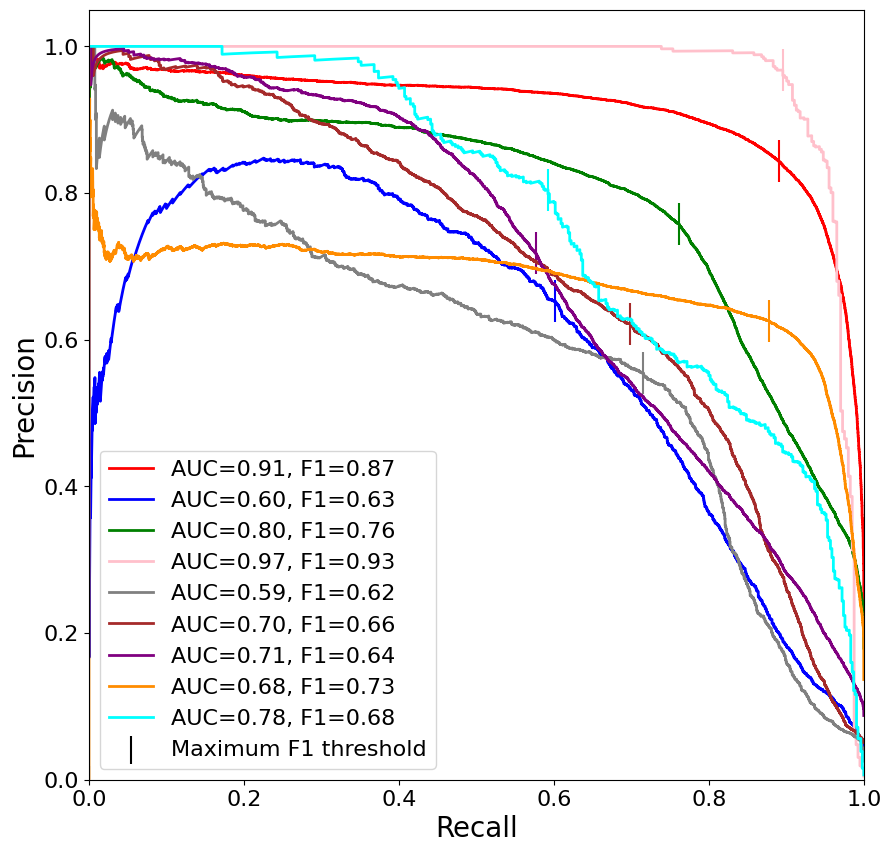

In [27]:
# Plot linewidth.
lw = 2
## n_classes -1 is to remove the unknown class
n_classes = len(label_binarizer.classes_)-1

# make prediction on testX for plotting
predY = preds
testY = efamY

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
roc_auc = dict()
roc_auprc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], predY[:, i])
    precision[i], recall[i], _ = precision_recall_curve(testY[:, i], predY[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auprc[i] = auc(recall[i], precision[i])



for i in range(n_classes):
    color = phrog_palette[label_binarizer.classes_[i]]
    fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    plt.scatter(recall[i][ix], precision[i][ix], marker='|', color=color, s=30**2)
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='AUC={0:0.2f}, F1={1:0.2f}'
             ''.format(roc_auprc[i], fscore[ix]))



plt.scatter(x=0, y=0, marker='|', color='black', s=20**2, label='Maximum F1 threshold')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)

plt.legend(loc="lower left")
plt.savefig('performance_efam_validation_AUPRC.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
## threshold based on F1 score
decision_threshold = {}
for i in range(len(label_binarizer.classes_)):

    precision, recall, thresholds = precision_recall_curve(testY[:, i], predY[:, i])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    print('Best Threshold %s= %f, F-Score=%.3f' % (label_binarizer.classes_[i], thresholds[ix], fscore[ix]))
    
    decision_threshold[label_binarizer.classes_[i]] = thresholds[ix]

Best Threshold DNA, RNA and nucleotide metabolism= 0.443589, F-Score=0.866
Best Threshold connector= 0.495186, F-Score=0.626
Best Threshold head and packaging= 0.436959, F-Score=0.760
Best Threshold integration and excision= 0.462480, F-Score=0.930
Best Threshold lysis= 0.218817, F-Score=0.625
Best Threshold moron, auxiliary metabolic gene and host takeover= 0.379751, F-Score=0.658
Best Threshold other= 0.483615, F-Score=0.640
Best Threshold tail= 0.490792, F-Score=0.731
Best Threshold transcription regulation= 0.736997, F-Score=0.682
Best Threshold unknown= 0.063377, F-Score=0.607


/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_65942/136521976.py:7: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


# figure 3b

In [29]:
cs_assignment = pd.read_csv('efam_clusters_predicted_model_phrog_family_train_ALL_familes_1_01102023.tsv', sep='\t')

In [30]:
phrog_predicted_clusters_dict = lb

In [31]:
cs_assignment_minus_phrogs = cs_assignment[~cs_assignment['cluster'].isin(phrog_predicted_clusters_dict.keys())]

In [32]:
len(cs_assignment_minus_phrogs)

159369

In [33]:
counts = []
for i in range(len(label_binarizer.classes_)):
    label_df = cs_assignment_minus_phrogs[cs_assignment_minus_phrogs['label'] == label_binarizer.classes_[i]]
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_df = pd.DataFrame({'category': list(label_binarizer.classes_), 'counts': counts})

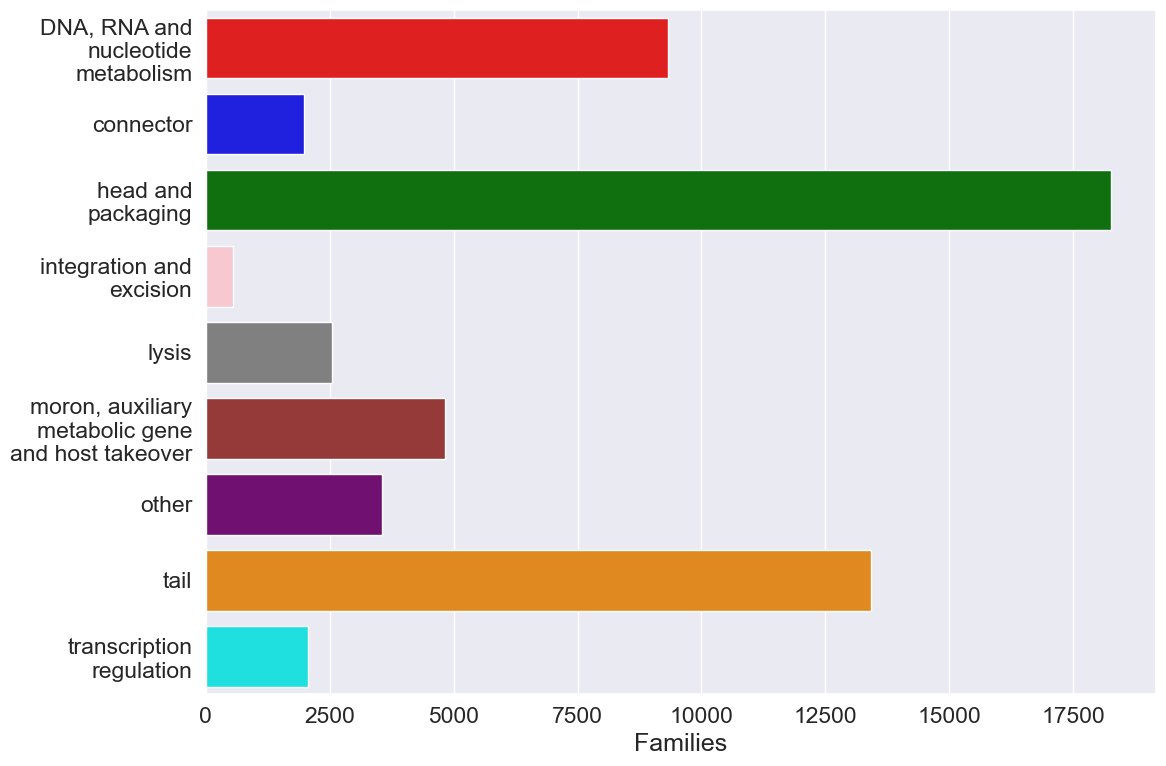

In [34]:
plt.rcParams["figure.figsize"]=12,8
sns.set(font_scale=1.5)
max_width=17

threshold_df_no_unknown = threshold_df[threshold_df['category'] != 'unknown']
g = sns.barplot(x='counts', y='category', palette=phrog_palette, data=threshold_df_no_unknown)

g.set_xlabel('Families')
g.set_ylabel('')
g.set_yticklabels(textwrap.fill(x.get_text(), max_width) for x in g.get_yticklabels())

plt.tight_layout()
plt.savefig('efam_clusters_not_PHROG_thresholded_to_max_f1_02212023', dpi=300, bbox_inches='tight')

### gain of method over PHROGs HMMs and EFAM internal annotation

In [35]:
efam_super_annote['cluster'] = efam_super_annote.index

In [36]:
efam_db_with_predictions = cs_assignment_minus_phrogs.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
efam_db_with_predictions_no_unannotated = efam_db_with_predictions[efam_db_with_predictions['Annotation Status'] == 'Unannotated']

In [37]:
counts = []
for i in range(len(label_binarizer.classes_)):
    label_df = efam_db_with_predictions_no_unannotated[efam_db_with_predictions_no_unannotated['label'] == label_binarizer.classes_[i]]
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_further_df = pd.DataFrame({'category': list(label_binarizer.classes_), 'counts': counts})

In [38]:
threshold_further_df

,category,counts
0,"DNA, RNA and nucleotide metabolism",5495
1,connector,1546
2,head and packaging,14625
3,integration and excision,195
4,lysis,2010
5,"moron, auxiliary metabolic gene and host takeover",2757
6,other,1714
7,tail,9654
8,transcription regulation,1262
9,unknown,89417


In [39]:
sum(threshold_further_df['counts'][:-1])

39258

# figure 3c

In [40]:
category = 'integration and excision'

In [41]:
clusters_with_integration_hhsearch_hit = [k for k,v in lb.items() if v[0] == 'integration and excision']

In [42]:
integration_excision_efam_followup = cs_assignment[(cs_assignment['cluster'].isin(clusters_with_integration_hhsearch_hit)) | (cs_assignment['label'] == category)]
integration_excision_efam_followup = integration_excision_efam_followup.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
integration_excision_efam_followup['decision_threshold'] = [1 if x > decision_threshold[category] else 0 for x in integration_excision_efam_followup['average_prob']]
integration_excision_efam_followup['efam_e12'] = [1 if x in phrog_predicted_clusters_dict.keys() else 0 for x in integration_excision_efam_followup['cluster']]
integration_excision_efam_followup['efam_e12_integration_and_excision'] = [1 if x in clusters_with_integration_hhsearch_hit else 0 for x in integration_excision_efam_followup['cluster']]

In [43]:
len(integration_excision_efam_followup)

1025

In [44]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16
plt.rcParams["figure.frameon"] = False

In [45]:
## remove the clusters not predicted integration and excision for the purposes of the figure
df = integration_excision_efam_followup
df = df[df['label'] == 'integration and excision']

/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_65942/2202343795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family integration and excision probability'] = df['average_prob']
/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_65942/2202343795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family average protein length'] = df['average_protein_length']
/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_65942/2202343795.py:3: SettingWithCopyWarning: 
A value is 

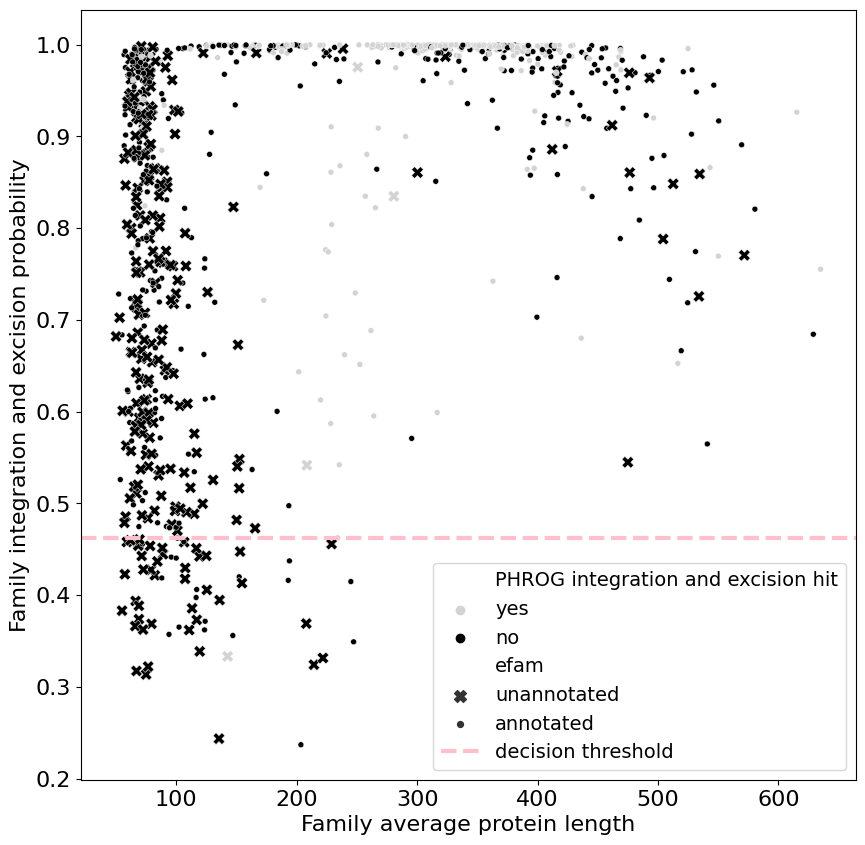

In [46]:
df['Family integration and excision probability'] = df['average_prob']
df['Family average protein length'] = df['average_protein_length']
df['PHROG integration and excision hit'] = ['yes' if x == 1 else 'no' for x in df['efam_e12_integration_and_excision']]
df['efam'] = ['annotated' if x == 'Annotated' else 'unannotated' for x in df['Annotation Status']]

plt.figure(frameon=False)
g = sns.scatterplot(
    y='Family integration and excision probability',
    x='Family average protein length',
    hue='PHROG integration and excision hit',
    palette=['lightgray', 'black'],
    hue_order=['yes','no'],
    style='efam',
    size_order=['unannotated', 'annotated'],
    size='efam',
    data=df
)

g.axhline(0.462480, color='pink', linestyle='--', lw=3, label='decision threshold')
g.legend(fontsize=14)

plt.savefig('efam_integration_excision_threshold.png', dpi=300, )

In [47]:
df_e12 = df[df['efam_e12_integration_and_excision'] == 0]
df_e12_threshold_1 = df_e12[df_e12['decision_threshold'] == 1]
df_filtered_e12_decision_threshold_unnanottated = df_e12_threshold_1[df_e12_threshold_1['Annotation Status'] == 'Unannotated']

In [48]:
df_e12_threshold_1_annotated = df_e12_threshold_1[df_e12_threshold_1['Annotation Status'] == 'Annotated']
df_e12_threshold_1_greater_100 = df_e12_threshold_1_annotated[df_e12_threshold_1_annotated['average_protein_length'] > 100]
df_e12_threshold_1_less_100 = df_e12_threshold_1_annotated[df_e12_threshold_1_annotated['average_protein_length'] < 100]

In [49]:
a = [ll.split('=')[0].split('\'') for l in list(df_e12_threshold_1_greater_100['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
a = [l[1].strip() for l in a if len(l) > 1]
a = [l.lower() for l in a if len(l) > 0]

b = [ll.split('=')[0].split('\'') for l in list(df_e12_threshold_1_less_100['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
b = [l[1].strip() for l in b if len(l) > 1]
b = [l.lower() for l in b if len(l) > 0]

In [50]:
a = pd.Series(a)
b = pd.Series(b)

In [51]:
list(a.value_counts()[a.value_counts() > 5].index)

['no annotation found',
 'very late expression factor 1',
 'phage integrase family',
 'phage_integrase domain-containing protein',
 'integrase',
 'uncharacterized protein',
 'phage integrase',
 'integrase family protein',
 'phage integrase family protein',
 'site-specific integrase',
 'putative phage integrase family protein',
 'hypothetical protein',
 'site-specific recombinase xerd',
 'site-specific recombinase',
 'tyrosine-type recombinase/integrase',
 'uncharacterized protein (fragment)',
 'putative phage integrase',
 'putative integrase',
 'tyrosine recombinase xerc',
 'phage integrase sam-like domain']

In [52]:
list(b.value_counts()[b.value_counts() > 5].index)

['no annotation found',
 'helix-turn-helix domain',
 'hth_17 domain-containing protein',
 'prophage cp4-57 regulatory protein (alpa)',
 'uncharacterized protein',
 'dna-binding protein',
 'hypothetical protein',
 'helix-turn-helix domain-containing protein']

## save clusters that meet threshold, are not annotated in PHROGs or EFAM

In [53]:
df_filtered_e12_decision_threshold_unnanottated.to_csv('efam_integration_and_excision_filtered.csv', index=False)